In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [104]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


In [105]:
data.Response.value_counts()

0    8753
1    1247
Name: Response, dtype: int64

**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [130]:
### Your code is here
from sklearn.preprocessing import OneHotEncoder
# cols_ohe = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
cols_ohe = data.select_dtypes('object').columns
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse=False), cols_ohe),
], remainder = 'passthrough')

In [108]:
import seaborn as sns
data.corr().style.background_gradient(sns.diverging_palette(5, 250, as_cmap=True), axis=1)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Age,1.000000,-0.081323,0.030638,-0.261456,0.081564,-0.576066,0.000030,0.113888
Driving_License,-0.081323,1.000000,0.004926,0.020464,-0.014338,0.044335,0.002704,0.011263
Region_Code,0.030638,0.004926,1.000000,-0.021270,-0.012213,-0.039733,-0.008527,0.010230
Previously_Insured,-0.261456,0.020464,-0.021270,1.000000,-0.005164,0.224719,0.022350,-0.333502
Annual_Premium,0.081564,-0.014338,-0.012213,-0.005164,1.000000,-0.123851,-0.008878,0.029839
Policy_Sales_Channel,-0.576066,0.044335,-0.039733,0.224719,-0.123851,1.000000,-0.006131,-0.146421
Vintage,0.000030,0.002704,-0.008527,0.022350,-0.008878,-0.006131,1.000000,-0.007187
Response,0.113888,0.011263,0.010230,-0.333502,0.029839,-0.146421,-0.007187,1.000000


**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, RocCurveDisplay, roc_auc_score

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([
    ('ct', ct),
    ('model', GradientBoostingClassifier(
        learning_rate=1,
        random_state=1,
        n_estimators=100
    ))
])
### Your code is here
pipe.fit(X_train, y_train)
y_pred_test = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

In [150]:
print(classification_report(y_test, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.904     0.931     0.917      1770
           1      0.311     0.239     0.270       230

    accuracy                          0.852      2000
   macro avg      0.607     0.585     0.594      2000
weighted avg      0.836     0.852     0.843      2000



In [152]:
round(f1_score(y_test, y_pred_test), 3)

0.27

0.828


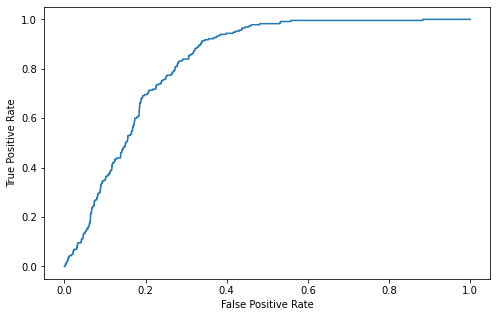

In [158]:
fpr, tpr, thresh = roc_curve(y_test, y_proba[:, 1:])
print(round(auc(fpr, tpr) , 3))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [157]:
y_proba

array([[9.98482679e-01, 1.51732090e-03],
       [5.86529124e-01, 4.13470876e-01],
       [9.99872894e-01, 1.27105663e-04],
       ...,
       [6.94821377e-01, 3.05178623e-01],
       [5.47781708e-01, 4.52218292e-01],
       [9.99424885e-01, 5.75114509e-04]])

In [141]:
pipe[1].feature_importances_

array([0.00479838, 0.0157812 , 0.01644749, 0.33280524, 0.20066166,
       0.00095635, 0.04120504, 0.02817371, 0.1765335 , 0.08334669,
       0.09929075])

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [160]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [197]:
### Your code is here
from sklearn.model_selection import GridSearchCV

pipes = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        # print(n_estimators, learning_rate)
        pipe = Pipeline([
            ('ct', ct),
            ('gbc', GradientBoostingClassifier(random_state=1,n_estimators=n_estimators, learning_rate=learning_rate,max_depth=5))
        ])
        pipe.fit(X_train, y_train)
        pipes.append(pipe)

In [199]:
from sklearn.metrics import f1_score

scores = []
for p in pipes:
    n_estimators = p.steps[1][1].n_estimators
    learning_rate = p.steps[1][1].learning_rate
    score = f1_score(y_test, p.predict(X_test), average='weighted')
    scores.append((n_estimators, learning_rate, score))
    
scores = pd.DataFrame(scores, columns=['n_estimators', 'learning_rate', 'score'])

<AxesSubplot:xlabel='learning_rate', ylabel='n_estimators'>

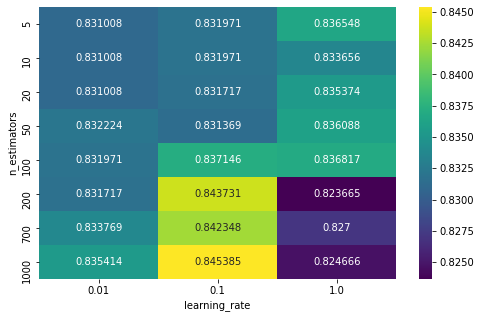

In [200]:
scores = pd.DataFrame(scores, columns=['n_estimators', 'learning_rate', 'score'])
result = scores.pivot(index='n_estimators', columns='learning_rate', values='score')

sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

In [201]:
scores.sort_values('score', ascending=False).head(5)

,n_estimators,learning_rate,score
22,1000,0.1,0.845385
16,200,0.1,0.843731
19,700,0.1,0.842348
13,100,0.1,0.837146
12,100,1.0,0.836817


**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [221]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

rf5 = []
for n_estimators in n_estimators_list:
    rf = Pipeline([
        ('ct', ct),
        ('rf', RandomForestClassifier(random_state=1, n_estimators=n_estimators, max_depth=5))
    ])
    rf.fit(X_train, y_train)
    score = f1_score(y_train, rf.predict(X_train), average='weighted')
    rf5.append((rf, score, n_estimators))
    
rf5000 = []
for n_estimators in n_estimators_list:
    rf = Pipeline([
        ('ct', ct),
        ('rf', RandomForestClassifier(random_state=1, n_estimators=n_estimators, max_depth=5000))
    ])
    rf.fit(X_train, y_train)
    score = f1_score(y_train, rf.predict(X_train), average='weighted')
    rf5000.append((rf, score, n_estimators))

gb5 = []
for n_estimators in n_estimators_list:
    gb = Pipeline([
        ('ct', ct),
        ('gb', GradientBoostingClassifier(random_state=1, n_estimators=n_estimators, max_depth=5))
    ])
    gb.fit(X_train, y_train)
    score = f1_score(y_train, gb.predict(X_train), average='weighted')
    gb5.append((gb, score, n_estimators))
    
gb5000 = []
for n_estimators in n_estimators_list:
    gb = Pipeline([
        ('ct', ct),
        ('gb', GradientBoostingClassifier(random_state=1, n_estimators=n_estimators, max_depth=5000))
    ])
    gb.fit(X_train, y_train)
    score = f1_score(y_train, rf.predict(X_train), average='weighted')
    gb5000.append((gb, score, n_estimators))
### Your code is here

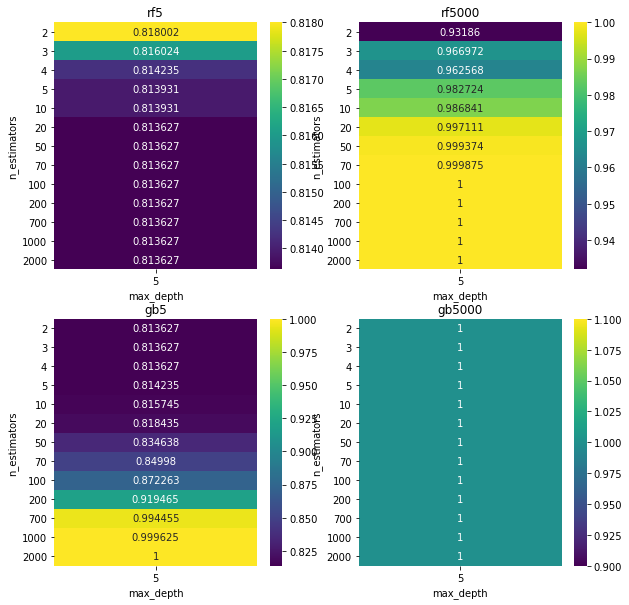

In [222]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(10,10))

def get_heatmap(ds):
    scores = []
    for r5 in ds:
        max_depth = 5
        score = r5[1]
        n_estimators = r5[2]
        scores.append((max_depth, n_estimators, score))
    
    scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'score'])
    result = scores.pivot(index='n_estimators', columns='max_depth', values='score')
    return result

for i, (dd, name) in enumerate([(rf5, 'rf5'), (rf5000, 'rf5000'), (gb5, 'gb5'), (gb5000, 'gb5000')]):
    sns.heatmap(get_heatmap(dd), annot=True, fmt="g", cmap='viridis', ax=axs.flat[i])
    axs.flat[i].title.set_text(name)

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [209]:
%load_ext autoreload
%autoreload 2

In [230]:
from catboost import CatBoostClassifier

### Your code is here
X = data.drop(columns=['Response'])
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

catb = CatBoostClassifier(verbose=0)

catb.fit(X_train, y_train,
    cat_features=list(X.select_dtypes('object').columns)
)

In [233]:
catb.feature_importances_

array([ 3.1033428 , 11.36658464,  0.03227638,  7.43228013, 27.35891126,
        4.74671151, 21.36760853,  9.26128996,  6.2198574 ,  9.11113739])

In [234]:
X.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

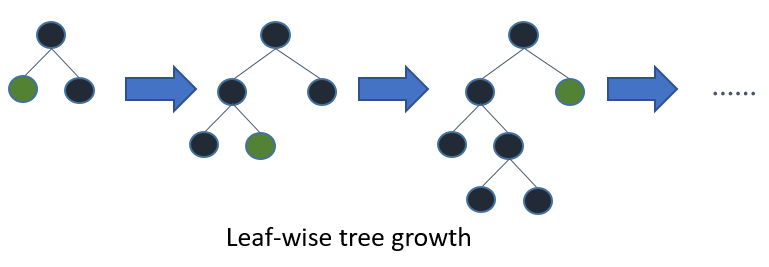

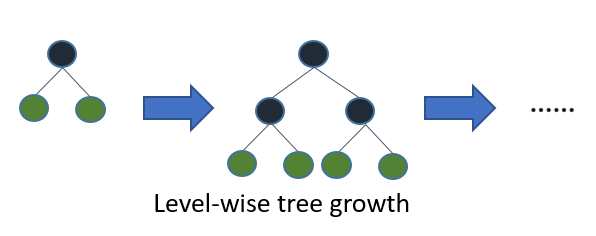

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [241]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

X = data.drop(columns=['Response'])
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

params = {'lgbm__n_estimators': [100, 500, 1000, 2000],
          'lgbm__max_depth': [2, 3, 5, 100],
          'lgbm__learning_rate': [0.1, 0.01, 0.001]}

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse=False), list(X_train.select_dtypes('object').columns)),
], remainder = 'passthrough')

### Your code is here
pipe = Pipeline([
    ('ct', ct),
    ('lgbm', LGBMClassifier())
])

grid = GridSearchCV(pipe, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage'])])),
                                       ('lgbm', LGBMClassifier())]),
             param_grid={'lgbm__learning_rate': [0.1, 0.01, 0.001],
                         'lgbm__max_depth': [2, 3, 5, 100],
                         'lgbm__n_estimators': [100, 500, 1000, 2000]})

In [242]:
print(classification_report(y_test, grid.predict(X_test), digits=2))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1770
           1       0.00      0.00      0.00       230

    accuracy                           0.89      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.78      0.89      0.83      2000



In [240]:
list(X_train.select_dtypes('object').columns)

['Gender', 'Vehicle_Age', 'Vehicle_Damage']